In [47]:
%load_ext autoreload
%autoreload complete

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib_inline.backend_inline import set_matplotlib_formats
from tqdm.notebook import tqdm

from src.cache import cache

set_matplotlib_formats("svg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
df = pd.read_csv(project_root / "data/daily_data.csv", parse_dates=["date"])
df.shape

(15344, 41)

In [49]:
instrument_names = dict(
    prcp="daily precipitation total in mm",
    snow="snow depth in mm",
    tavg="average air temperature in °C",
    tmax="maximum air temperature in °C",
    tmin="minimum air temperature in °C",
    wdir="wind direction",
    wspd="average wind speed in km/h",
    wpgt="peak wind gust in km/h",
    tsun="daily sunshine total in minutes (m)",
    pres="average sea-level air pressure in hPa",
)

In [50]:
count = df["count_moderate"] + df["count_radical"]
size = df["size_moderate"] + df["size_radical"]
df["t_protests"] = count > 0
df["t_radical"] = df["count_radical"] > 0
df["t_50"] = size > 50
df["t_500"] = size > 500
df["t_5000"] = size > 5000
treatments = [col for col in df.columns if col.startswith("t_")]
for t in treatments:
    df[t] = df[t].astype(int)
    print(t, df[t].sum())
df["t_size"] = np.log2(size + 1)
treatments.append("t_size")
protests = df.query(f"t_size > 0")
df.head()

t_protests 375
t_radical 98
t_50 154
t_500 61
t_5000 21


date               region  size_radical  size_moderate  count_radical  \
0 2020-01-01  Nordrhein-Westfalen           0.0            0.0            0.0   
1 2020-01-01              Hamburg           0.0            0.0            0.0   
2 2020-01-01               Hessen           0.0            0.0            0.0   
3 2020-01-01               Bayern           0.0            0.0            0.0   
4 2020-01-01        Niedersachsen           0.0            0.0            0.0   

   count_moderate  climate_and_protest_mediacloud  \
0             0.0                              10   
1             0.0                               5   
2             0.0                              18   
3             0.0                               1   
4             0.0                               4   

   climate_not_protest_mediacloud  climate_mediacloud  instr_prcp  ...  \
0                              42                  52         0.0  ...   
1                               9                  14         0.0  ...   
2                              58                  76         0.0  ...   
3                              21                  22         0.0  ...   
4                              24                  28         0.0  ...   

   size_moderate_official  size_radical_official  count_moderate_official  \
0                     0.0                    0.0                      0.0   
1                     NaN                    NaN                      NaN   
2                     0.0                    0.0                      0.0   
3                     0.0                    0.0                      0.0   
4                     NaN                    NaN                      NaN   

   count_radical_official  t_protests  t_radical  t_50  t_500  t_5000  t_size  
0                     0.0           0          0     0      0       0     0.0  
1                     NaN           0          0     0      0       0     0.0  
2                     0.0           0          0     0      0       0     0.0  
3                     0.0           0          0     0      0       0     0.0  
4                     NaN           0          0     0      0       0     0.0  

[5 rows x 47 columns]

In [51]:
df = df.drop(
    columns=["instr_tsun", "instr_longterm_tsun", "instr_wdir", "instr_longterm_wdir"]
)

In [52]:
df = df.rename(
    columns={
        col: col.replace("longterm_", "") + ("_longterm" if "longterm" in col else "")
        for col in df.columns
    }
)

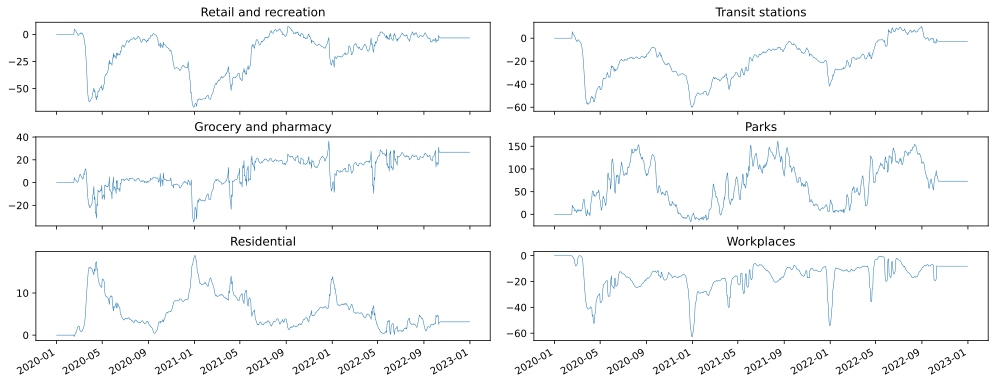

In [53]:
# | label: fig-covid-19-time-series
# | fig-cap: "Time series of Covid-19 variables from Google Mobility Trends. The y-axis gives the change in visitor numbers for various locations in comparison to the pre-pandemic level, as a rolling 7-day average. Absolute numbers between the different categories are not comparable."
# | column: page

covid_instruments = [
    "instr_retail_and_recreation",
    "instr_grocery_and_pharmacy",
    "instr_residential",
    "instr_transit_stations",
    "instr_parks",
    "instr_workplaces",
]
n = 3
# df_ = df.query("region == 'Berlin'")
fig, ax = plt.subplots(n, 2, figsize=(14, 6), sharex=True)
for i, instr in enumerate(covid_instruments):
    ax[i % n, i // n].plot(df["date"], df[instr], linewidth=0.5)
    ax[i % n, i // n].set_title(
        instr.replace("instr_", "").replace("_", " ").capitalize()
    )
fig.tight_layout()
# format xticks with dates
fig.autofmt_xdate()
plt.show()

In [54]:
from munch import Munch

original = [c for c in df.columns if c.startswith("instr_") and not "longterm" in c][:8]
longterm = [c for c in df.columns if c.startswith("instr_") and "longterm" in c]

instruments = Munch(
    original=original,
    longterm=longterm,
    longterm_smoothed=[f"{instr}_smoothed" for instr in longterm],
    daily=[f"{instr}_daily" for instr in original],
)

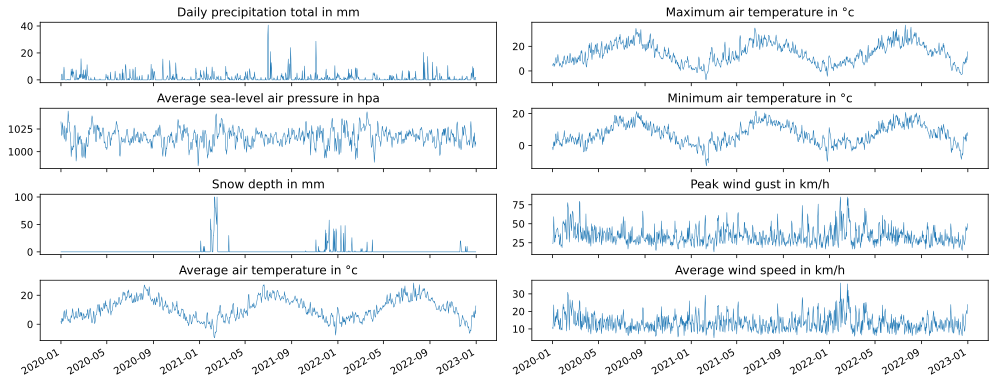

In [55]:
# | label: fig-weather-time-series
# | fig-cap: "Time series of the weather variables, here plotted for Berlin."
# | column: page

n = 4
df_ = df.query("region == 'Berlin'")
fig, ax = plt.subplots(n, 2, figsize=(14, 6), sharex=True)
for i, instr in enumerate(instruments.original):
    ax[i % n, i // n].plot(df_["date"], df_[instr], linewidth=0.5)
    ax[i % n, i // n].set_title(
        instrument_names[instr.replace("instr_", "")].capitalize()
    )
fig.tight_layout()
# format xticks with dates
fig.autofmt_xdate()
plt.show()

In [56]:
for instr in [
    "instr_retail_and_recreation",
    "instr_grocery_and_pharmacy",
    "instr_residential",
    "instr_transit_stations",
    "instr_parks",
    "instr_workplaces",
]:
    df[instr + "_daily"] = df[instr]

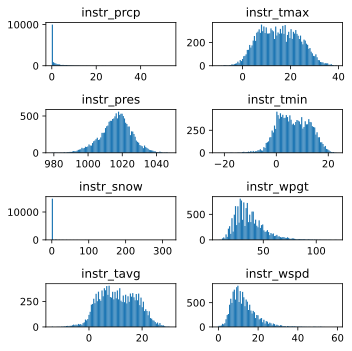

In [58]:
n = 4
fig, ax = plt.subplots(n, 2, figsize=(5, 5))
for i, instr in enumerate(instruments.original[:8]):
    ax[i % n, i // n].hist(df[instr], bins=100)
    ax[i % n, i // n].set_title(instr)
plt.tight_layout()
plt.show()

<Axes: >

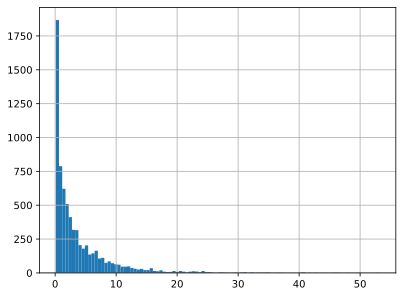

In [59]:
df.query("instr_prcp > 0")["instr_prcp"].hist(bins=100)

<Axes: >

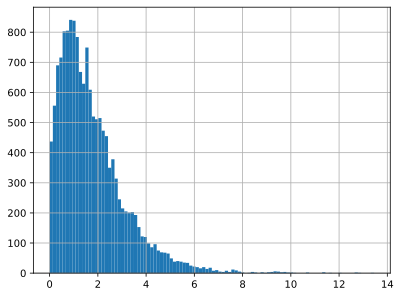

In [60]:
df["instr_prcp_longterm"].hist(bins=100)

<Axes: >

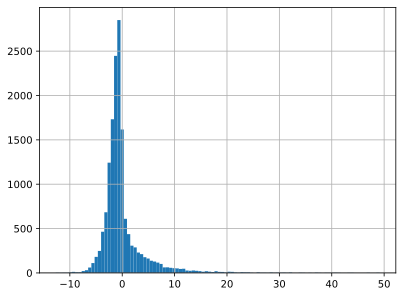

In [61]:
(df["instr_prcp"] - df["instr_prcp_longterm"]).hist(bins=100)

In [62]:
df["instr_prcp"] = np.log(df["instr_prcp"] + 1)
df["instr_snow"] = np.log(df["instr_snow"] + 1)
df["instr_wspd"] = np.log(df["instr_wspd"] + 1)
df["instr_wpgt"] = np.log(df["instr_wpgt"] + 1)

df["instr_prcp_longterm"] = np.log(df["instr_prcp_longterm"] + 1)
df["instr_snow_longterm"] = np.log(df["instr_snow_longterm"] + 1)
df["instr_wspd_longterm"] = np.log(df["instr_wspd_longterm"] + 1)
df["instr_wpgt_longterm"] = np.log(df["instr_wpgt_longterm"] + 1)

In [63]:
df = df.sort_values(["region", "date"])

for longterm, longterm_smoothed in zip(
    instruments.longterm, instruments.longterm_smoothed
):
    df[longterm_smoothed] = (
        df.groupby("region")[longterm]
        .rolling(window=28, win_type="gaussian", center=True, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )

for o, ls, d in zip(
    instruments.original, instruments.longterm_smoothed, instruments.daily
):
    df[d] = df[o] - df[ls]

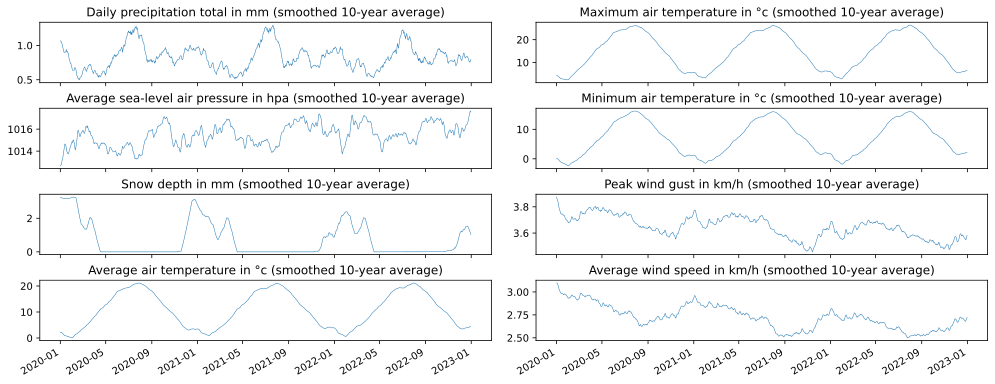

In [64]:
n = 4
df_ = df.query("region == 'Berlin'")
fig, ax = plt.subplots(n, 2, figsize=(14, 6), sharex=True)
for i, contr in enumerate(instruments.longterm_smoothed[:8]):
    ax[i % n, i // n].plot(df_["date"], df_[contr], linewidth=0.5)
    ax[i % n, i // n].set_title(
        instrument_names[
            contr.replace("instr_", "").replace("_longterm_smoothed", "")
        ].capitalize()
        + " (smoothed 10-year average)"
    )
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

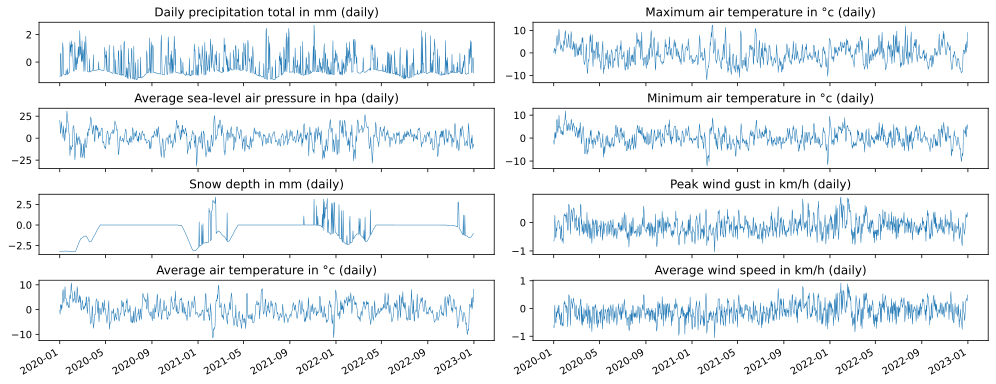

In [65]:
# | label: fig-weather-time-series-2
# | fig-cap: "Time series of the weather variables used as instruments, here plotted for Berlin. Seasonal and spatial features have been removed by subtracting the 10-year average (specifically, its 14-day centered rolling mean) for each day of the year and each location."
# | column: page

n = 4
df_ = df.query("region == 'Berlin'")
fig, ax = plt.subplots(n, 2, figsize=(14, 6), sharex=True)
for i, contr in enumerate(instruments.daily[:8]):
    ax[i % n, i // n].plot(df_["date"], df_[contr], linewidth=0.5)
    ax[i % n, i // n].set_title(
        instrument_names[contr.replace("instr_", "").replace("_daily", "")].capitalize()
        + " (daily)"
    )
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

<Axes: >

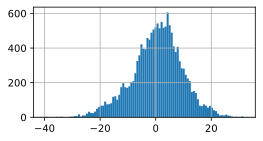

In [66]:
df["instr_pres_daily"].hist(bins=100, figsize=(4, 2))

<Axes: >

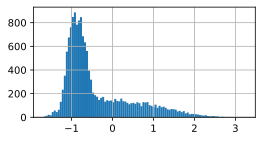

In [67]:
df["instr_prcp_daily"].hist(bins=100, figsize=(4, 2))

<Axes: >

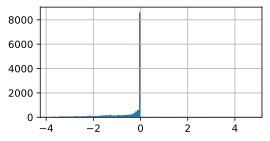

In [68]:
df["instr_snow_daily"].hist(bins=100, figsize=(4, 2))

In [69]:
for instr in (
    instruments.original
    + instruments.longterm
    + instruments.longterm_smoothed
    + instruments.daily
):
    df[instr] = (df[instr] - df[instr].mean()) / df[instr].std()

In [70]:
# %%capture

# from munch import Munch
# from copy import deepcopy


# from itertools import chain

# for type_ in ["original", "diffs", "controls"]:
#     names = deepcopy(instruments[type_])
#     for instr in names:
#         for threshold in [-2, -1, 0, 1, 2]:
#             name = f"{instr} > {threshold}"
#             df[name] = (df[instr] > threshold).astype(int)
#             instruments[type_].append(name)

In [71]:
%%capture

df = df.sort_values(["region", "date"])
for day in tqdm(np.arange(-3 * 28, 3 * 28 + 1)):
    for predictor in (
        instruments.original + instruments.longterm_smoothed + instruments.daily
    ):
        var = f"{predictor}_{day}"
        df[var] = (
            df.groupby("region")[predictor].shift(day).fillna(0)
        )  # .reset_index(0,drop=True)

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_1383/2559573588.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["test_day_0"] = df.groupby("region")["instr_prcp"].shift(0)


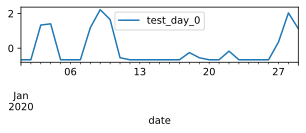

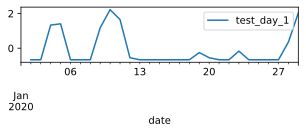

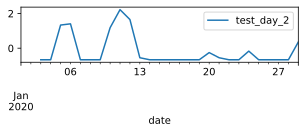

In [72]:
df["test_day_0"] = df.groupby("region")["instr_prcp"].shift(0)
df.query("region == 'Berlin' & date < '2020-01-30'").plot(
    "date", "test_day_0", figsize=(5, 1)
)
plt.show()
df["test_day_1"] = df.groupby("region")["instr_prcp"].shift(1)
df.query("region == 'Berlin' & date < '2020-01-30'").plot(
    "date", "test_day_1", figsize=(5, 1)
)
plt.show()
df["test_day_2"] = df.groupby("region")["instr_prcp"].shift(2)
df.query("region == 'Berlin' & date < '2020-01-30'").plot(
    "date", "test_day_2", figsize=(5, 1)
)
plt.show()

<Axes: >

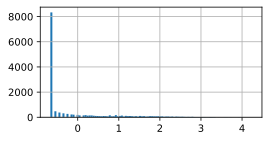

In [106]:
df["instr_prcp_0"].hist(bins=100, figsize=(4, 2))

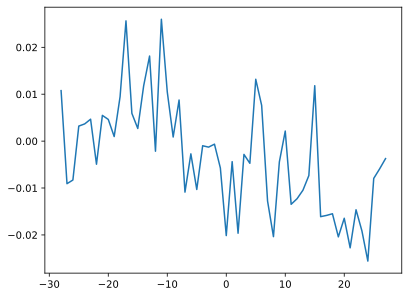

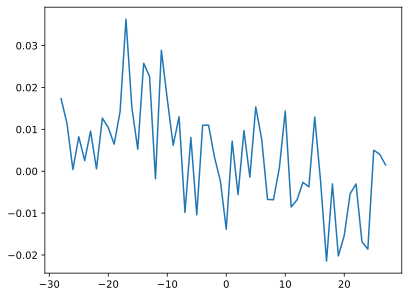

In [108]:
days, corrs = zip(
    *[
        (i, np.corrcoef(df[f"instr_prcp_daily_{i}"], df["t_protests"])[0, 1])
        for i in range(-28, 28)
    ]
)
plt.plot(days, corrs)
plt.show()
days, corrs = zip(
    *[
        (i, np.corrcoef(df[f"instr_prcp_{i}"] > -0.6, df["t_protests"])[0, 1])
        for i in range(-28, 28)
    ]
)
plt.plot(days, corrs)
plt.show()

Without control for climate:

In [73]:
region_dummies = pd.get_dummies(df["region"], drop_first=True).reset_index(0, drop=True)
df = pd.concat([df, region_dummies], axis=1)
region_dummies = region_dummies.columns.tolist()

In [74]:
df[region_dummies]

Berlin  Brandenburg  Bremen  Hamburg  Hessen  Niedersachsen  \
3           0            0       0        0       0              0   
17          0            0       0        0       0              0   
31          0            0       0        0       0              0   
45          0            0       0        0       0              0   
59          0            0       0        0       0              0   
...       ...          ...     ...      ...     ...            ...   
15284       0            0       0        0       0              0   
15298       0            0       0        0       0              0   
15312       0            0       0        0       0              0   
15326       0            0       0        0       0              0   
15340       0            0       0        0       0              0   

       Nordrhein-Westfalen  Rheinland-Pfalz  Saarland  Sachsen  \
3                        0                0         0        0   
17                       0                0         0        0   
31                       0                0         0        0   
45                       0                0         0        0   
59                       0                0         0        0   
...                    ...              ...       ...      ...   
15284                    0                0         0        0   
15298                    0                0         0        0   
15312                    0                0         0        0   
15326                    0                0         0        0   
15340                    0                0         0        0   

       Sachsen-Anhalt  Schleswig-Holstein  Thüringen  
3                   0                   0          0  
17                  0                   0          0  
31                  0                   0          0  
45                  0                   0          0  
59                  0                   0          0  
...               ...                 ...        ...  
15284               0                   0          1  
15298               0                   0          1  
15312               0                   0          1  
15326               0                   0          1  
15340               0                   0          1  

[15344 rows x 13 columns]

In [75]:
p_threshold = 0.25

In [76]:
# X.isna().sum()

In [77]:
# instruments.original = [x for x in instruments.original if x not in ["instr_wspd", "instr_wpgt"]]
# instruments.daily = [x for x in instruments.daily if x not in ["instr_wspd_daily", "instr_wpgt_daily"]]
# instruments.longterm_smoothed = [x for x in instruments.longterm_smoothed if x not in ["instr_wspd_longterm_smoothed", "instr_wpgt_longterm_smoothed"]]
# instruments.longterm = [x for x in instruments.longterm if x not in ["instr_wspd_longterm", "instr_wpgt_longterm"]]

In [78]:
X = df[instruments.original + region_dummies]
X = sm.add_constant(X)
y = df["t_protests"]
results = sm.OLS(y, X).fit()
results_protest = results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             t_protests   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.147
Date:                Fri, 23 Jun 2023   Prob (F-statistic):            0.00171
Time:                        10:46:30   Log-Likelihood:                 6915.2
No. Observations:               15344   AIC:                        -1.379e+04
Df Residuals:                   15322   BIC:                        -1.362e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0352      0.005      6.980      0.000       0.025       0.045
instr_prcp             -0.0039      0.001     -2.585      0.010      -0.007      -0.001
instr_pres             -0.0009      0.001     -0.580      0.562      -0.004       0.002
instr_snow             -0.0004      0.001     -0.311      0.755      -0.003       0.002
instr_tavg             -0.0008      0.015     -0.055      0.956      -0.029       0.028
instr_tmax             -0.0066      0.010     -0.681      0.496      -0.025       0.012
instr_tmin              0.0061      0.007      0.937      0.349      -0.007       0.019
instr_wpgt              0.0015      0.002      0.683      0.495      -0.003       0.006
instr_wspd             -0.0016      0.002     -0.718      0.473      -0.006       0.003
Berlin                 -0.0132      0.007     -1.904      0.057      -0.027       0.000
Brandenburg            -0.0050      0.008     -0.632      0.528      -0.020       0.010
Bremen                 -0.0120      0.007     -1.685      0.092      -0.026       0.002
Hamburg                -0.0243      0.007     -3.569      0.000      -0.038      -0.011
Hessen                 -0.0187      0.007     -2.738      0.006      -0.032      -0.005
Niedersachsen          -0.0067      0.007     -0.935      0.350      -0.021       0.007
Nordrhein-Westfalen    -0.0166      0.008     -2.149      0.032      -0.032      -0.001
Rheinland-Pfalz        -0.0122      0.007     -1.793      0.073      -0.025       0.001
Saarland               -0.0114      0.007     -1.719      0.086      -0.024       0.002
Sachsen                -0.0157      0.007     -2.316      0.021      -0.029      -0.002
Sachsen-Anhalt         -0.0009      0.008     -0.117      0.907      -0.016       0.014
Schleswig-Holstein     -0.0162      0.008     -2.136      0.033      -0.031      -0.001
Thüringen               0.0024      0.007      0.356      0.722      -0.011       0.016
==============================================================================
Omnibus:                    17194.453   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           912511.331
Skew:                           6.133   Prob(JB):                         0.00
Kurtosis:                      38.733   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
results.pvalues[["const"] + instruments.original]

const         3.078134e-12
instr_prcp    9.743039e-03
instr_pres    5.619280e-01
instr_snow    7.554438e-01
instr_tavg    9.558769e-01
instr_tmax    4.955656e-01
instr_tmin    3.489862e-01
instr_wpgt    4.946300e-01
instr_wspd    4.726441e-01
dtype: float64

In [80]:
import statsmodels.stats.multitest as smm

params, pvalues = (
    results.params[instruments.original],
    results.pvalues[instruments.original],
)

reject_bh, pvals_adj_bh, _, _ = smm.multipletests(
    pvalues, alpha=p_threshold, method="fdr_by"
)
pval_df = pd.DataFrame(
    {
        "coef": params[reject_bh],
        "p": pvalues[reject_bh],
        "p_adj": pvals_adj_bh[reject_bh],
    },
    index=pvalues[reject_bh].index,
)
# format numbers legibly
pval_df["coef"] = pval_df["coef"].apply(lambda x: f"{x:.3f}")
pval_df["p"] = pval_df["p"].apply(lambda x: f"{x:.4f}")
pval_df["p_adj"] = pval_df["p_adj"].apply(lambda x: f"{x:.4f}")
pval_df_protests = pval_df.copy()
pval_df

coef       p   p_adj
instr_prcp  -0.004  0.0097  0.2118

In [81]:
protests[instruments.original].isna().sum()

instr_prcp    0
instr_pres    0
instr_snow    0
instr_tavg    0
instr_tmax    0
instr_tmin    0
instr_wpgt    0
instr_wspd    0
dtype: int64

In [82]:
protests = df.query("t_protests > 0")
X = protests[instruments.original + region_dummies]
X = sm.add_constant(X)
y = protests["t_size"]
results = sm.OLS(y, X).fit()
results_protest = results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 t_size   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     5.972
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           4.49e-14
Time:                        10:46:42   Log-Likelihood:                -1004.3
No. Observations:                 375   AIC:                             2053.
Df Residuals:                     353   BIC:                             2139.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.5478      0.677      9.674      0.000       5.217       7.879
instr_prcp              0.0097      0.227      0.043      0.966      -0.437       0.456
instr_pres             -0.4473      0.250     -1.786      0.075      -0.940       0.045
instr_snow             -0.0110      0.228     -0.048      0.962      -0.460       0.438
instr_tavg              6.0699      2.302      2.637      0.009       1.543      10.597
instr_tmax             -3.9054      1.534     -2.545      0.011      -6.923      -0.888
instr_tmin             -1.6817      1.033     -1.627      0.105      -3.714       0.351
instr_wpgt              0.0615      0.341      0.180      0.857      -0.610       0.733
instr_wspd             -0.6760      0.348     -1.942      0.053      -1.361       0.009
Berlin                 -3.4176      1.107     -3.088      0.002      -5.594      -1.241
Brandenburg            -2.3527      1.132     -2.078      0.038      -4.580      -0.126
Bremen                  0.1248      1.067      0.117      0.907      -1.974       2.223
Hamburg                -3.7397      1.149     -3.255      0.001      -5.999      -1.480
Hessen                  0.9808      1.105      0.887      0.375      -1.193       3.155
Niedersachsen          -1.9199      1.036     -1.853      0.065      -3.958       0.118
Nordrhein-Westfalen    -1.5572      1.217     -1.280      0.201      -3.950       0.836
Rheinland-Pfalz         2.3929      0.960      2.493      0.013       0.505       4.280
Saarland               -2.5204      0.905     -2.784      0.006      -4.301      -0.740
Sachsen                -0.5516      1.095     -0.504      0.615      -2.705       1.602
Sachsen-Anhalt         -3.7047      1.024     -3.616      0.000      -5.719      -1.690
Schleswig-Holstein      1.3860      1.134      1.223      0.222      -0.843       3.615
Thüringen              -3.6602      0.873     -4.194      0.000      -5.376      -1.944
==============================================================================
Omnibus:                        5.885   Durbin-Watson:                   2.233
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.430
Skew:                          -0.238   Prob(JB):                       0.0662
Kurtosis:                       2.651   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
import statsmodels.stats.multitest as smm

params, pvalues = (
    results.params[instruments.original],
    results.pvalues[instruments.original],
)
reject_bh, pvals_adj_bh, _, _ = smm.multipletests(
    pvalues, alpha=p_threshold, method="fdr_by"
)
pval_df = pd.DataFrame(
    {
        "coef": params[reject_bh],
        "p": pvalues[reject_bh],
        "p_adj": pvals_adj_bh[reject_bh],
    },
    index=pvalues[reject_bh].index,
)
# format numbers legibly
pval_df["coef"] = pval_df["coef"].apply(lambda x: f"{x:.3f}")
pval_df["p"] = pval_df["p"].apply(lambda x: f"{x:.4f}")
pval_df["p_adj"] = pval_df["p_adj"].apply(lambda x: f"{x:.4f}")
pval_df_size = pval_df.copy()
pval_df

coef       p   p_adj
instr_tavg   6.070  0.0087  0.1233
instr_tmax  -3.905  0.0113  0.1233

In [84]:
pval_df = pd.concat([pval_df_protests, pval_df_size], axis=1)


def pval_table(pval_df):
    # only keep rows where the index begins with "instr_" or "const"
    pval_df = pval_df[
        pval_df.index.str.startswith("instr_") | pval_df.index.str.startswith("const")
    ]

    def _rename(x):
        if x == "const":
            return "intercept"
        x = x.replace("instr_", "")
        y = x.replace("_daily", "").replace("_longterm_smoothed", "")
        name = instrument_names[y] if y in instrument_names else y
        if "longterm" in x:
            name = name + " (10-year avg.)"
        return name

    pval_df.index = pval_df.index.map(_rename)

    # replace nan with empty string
    pval_df = pval_df.replace(np.nan, "", regex=True)

    # add high-level headers
    pval_df.columns = pd.MultiIndex.from_tuples(
        [
            ("protest occurrence", "coef"),
            ("protest occurrence", "p"),
            ("protest occurrence", "p_adj"),
            ("protest size", "coef"),
            ("protest size", "p"),
            ("protest size", "p_adj"),
        ]
    )

    return pval_df


pval_table_without_control = pval_table(pval_df)
pval_table_without_control

protest occurrence                  \
                                              coef       p   p_adj   
daily precipitation total in mm             -0.004  0.0097  0.2118   
average air temperature in °C                                        
maximum air temperature in °C                                        

                                protest size                  
                                        coef       p   p_adj  
daily precipitation total in mm                               
average air temperature in °C          6.070  0.0087  0.1233  
maximum air temperature in °C         -3.905  0.0113  0.1233

With control for climate:

In [85]:
X = df[instruments.daily + instruments.longterm_smoothed + region_dummies]
X = sm.add_constant(X)
y = df["t_protests"]
results = sm.OLS(y, X).fit()
results_protest = results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             t_protests   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.370
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           2.45e-09
Time:                        10:46:47   Log-Likelihood:                 6941.5
No. Observations:               15344   AIC:                        -1.382e+04
Df Residuals:                   15314   BIC:                        -1.359e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.0273      0.007      3.993      0.000       0.014       0.041
instr_prcp_daily                -0.0049      0.002     -3.214      0.001      -0.008      -0.002
instr_pres_daily                -0.0019      0.001     -1.290      0.197      -0.005       0.001
instr_snow_daily                -0.0020      0.002     -0.924      0.356      -0.006       0.002
instr_tavg_daily                -0.0002      0.007     -0.034      0.973      -0.015       0.014
instr_tmax_daily                -0.0034      0.005     -0.670      0.503      -0.013       0.007
instr_tmin_daily                 0.0015      0.004      0.390      0.696      -0.006       0.009
instr_wpgt_daily                 0.0012      0.002      0.561      0.575      -0.003       0.006
instr_wspd_daily                 0.0006      0.002      0.249      0.803      -0.004       0.005
instr_prcp_longterm_smoothed     0.0066      0.002      3.863      0.000       0.003       0.010
instr_pres_longterm_smoothed     0.0013      0.002      0.865      0.387      -0.002       0.004
instr_snow_longterm_smoothed     0.0083      0.003      2.784      0.005       0.002       0.014
instr_tavg_longterm_smoothed    -0.0256      0.057     -0.451      0.652      -0.137       0.086
instr_tmax_longterm_smoothed     0.0193      0.034      0.574      0.566      -0.047       0.085
instr_tmin_longterm_smoothed     0.0122      0.026      0.479      0.632      -0.038       0.062
instr_wpgt_longterm_smoothed    -0.0099      0.003     -3.289      0.001      -0.016      -0.004
instr_wspd_longterm_smoothed     0.0089      0.003      2.901      0.004       0.003       0.015
Berlin                           0.0018      0.009      0.206      0.837      -0.015       0.019
Brandenburg                     -0.0013      0.011     -0.121      0.904      -0.023       0.020
Bremen                          -0.0064      0.009     -0.689      0.491      -0.025       0.012
Hamburg                         -0.0234      0.007     -3.237      0.001      -0.038      -0.009
Hessen                          -0.0049      0.008     -0.646      0.518      -0.020       0.010
Niedersachsen                    0.0053      0.010      0.554      0.580      -0.014       0.024
Nordrhein-Westfalen             -0.0126      0.011     -1.159      0.246      -0.034       0.009
Rheinland-Pfalz                 -0.0028      0.009     -0.326      0.745      -0.020       0.014
Saarland                        -0.0050      0.007     -0.698      0.485      -0.019       0.009
Sachsen                          0.0019      0.008      0.229      0.819      -0.014       0.018
Sachsen-Anhalt                   0.0048      0.010      0.466      0.641      -0.015       0.025
Schleswig-Holstein              -0.0119      0.010     -1.172      0.241    

In [86]:
import statsmodels.stats.multitest as smm

params, pvalues = results.params[instruments.daily], results.pvalues[instruments.daily]
reject_bh, pvals_adj_bh, _, _ = smm.multipletests(
    pvalues, alpha=p_threshold, method="fdr_by"
)
pval_df = pd.DataFrame(
    {
        "coef": params[reject_bh],
        "p": pvalues[reject_bh],
        "p_adj": pvals_adj_bh[reject_bh],
    },
    index=pvalues[reject_bh].index,
)
# format numbers legibly
pval_df["coef"] = pval_df["coef"].apply(lambda x: f"{x:.3f}")
pval_df["p"] = pval_df["p"].apply(lambda x: f"{x:.4f}")
pval_df["p_adj"] = pval_df["p_adj"].apply(lambda x: f"{x:.4f}")
pval_df_protests = pval_df.copy()
pval_df

coef       p   p_adj
instr_prcp_daily  -0.005  0.0013  0.0285

In [87]:
X = protests[instruments.daily + instruments.longterm_smoothed + region_dummies]
X = sm.add_constant(X)
y = protests["t_size"]
results = sm.OLS(y, X).fit()
results_size = results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 t_size   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     5.115
Date:                Fri, 23 Jun 2023   Prob (F-statistic):           2.09e-14
Time:                        10:46:49   Log-Likelihood:                -994.20
No. Observations:                 375   AIC:                             2048.
Df Residuals:                     345   BIC:                             2166.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.9059      1.122      7.939      0.000       6.699      11.112
instr_prcp_daily                 0.1451      0.233      0.623      0.533      -0.313       0.603
instr_pres_daily                -0.4785      0.253     -1.895      0.059      -0.975       0.018
instr_snow_daily                -0.0845      0.371     -0.228      0.820      -0.815       0.646
instr_tavg_daily                 2.4998      1.149      2.175      0.030       0.239       4.760
instr_tmax_daily                -1.8946      0.795     -2.384      0.018      -3.458      -0.331
instr_tmin_daily                -0.8786      0.598     -1.468      0.143      -2.056       0.298
instr_wpgt_daily                 0.1984      0.344      0.577      0.564      -0.477       0.874
instr_wspd_daily                -0.9141      0.365     -2.506      0.013      -1.632      -0.197
instr_prcp_longterm_smoothed    -0.3343      0.280     -1.194      0.233      -0.885       0.217
instr_pres_longterm_smoothed     0.4423      0.275      1.607      0.109      -0.099       0.984
instr_snow_longterm_smoothed    -0.1295      0.497     -0.261      0.794      -1.106       0.847
instr_tavg_longterm_smoothed     3.1770      8.569      0.371      0.711     -13.677      20.031
instr_tmax_longterm_smoothed    -2.0984      5.251     -0.400      0.690     -12.426       8.229
instr_tmin_longterm_smoothed     1.0198      3.755      0.272      0.786      -6.366       8.406
instr_wpgt_longterm_smoothed     0.5122      0.469      1.093      0.275      -0.410       1.434
instr_wspd_longterm_smoothed    -0.1477      0.478     -0.309      0.757      -1.088       0.792
Berlin                          -6.1405      1.542     -3.982      0.000      -9.174      -3.107
Brandenburg                     -6.3160      1.715     -3.683      0.000      -9.689      -2.943
Bremen                          -3.1215      1.616     -1.931      0.054      -6.301       0.058
Hamburg                         -4.2566      1.249     -3.408      0.001      -6.714      -1.800
Hessen                          -1.5352      1.425     -1.077      0.282      -4.338       1.267
Niedersachsen                   -5.1056      1.545     -3.305      0.001      -8.144      -2.067
Nordrhein-Westfalen             -5.5757      1.816     -3.071      0.002      -9.147      -2.005
Rheinland-Pfalz                  0.2048      1.460      0.140      0.889      -2.667       3.076
Saarland                        -2.7921      0.964     -2.898      0.004      -4.687      -0.897
Sachsen                         -2.4115      1.362     -1.770      0.078      -5.091       0.268
Sachsen-Anhalt                  -7.2038      1.604     -4.491      0.000     -10.359      -4.049
Schleswig-Holstein              -2.1118      1.642     -1.286      0.199    

In [88]:
import statsmodels.stats.multitest as smm

protests = df.query("t_protests > 0")
params, pvalues = results.params[instruments.daily], results.pvalues[instruments.daily]
reject_bh, pvals_adj_bh, _, _ = smm.multipletests(
    pvalues, alpha=p_threshold, method="fdr_by"
)
pval_df = pd.DataFrame(
    {
        "coef": params[reject_bh],
        "p": pvalues[reject_bh],
        "p_adj": pvals_adj_bh[reject_bh],
    },
    index=pvalues[reject_bh].index,
)
# format numbers legibly
pval_df["coef"] = pval_df["coef"].apply(lambda x: f"{x:.3f}")
pval_df["p"] = pval_df["p"].apply(lambda x: f"{x:.4f}")
pval_df["p_adj"] = pval_df["p_adj"].apply(lambda x: f"{x:.4f}")
pval_df_size = pval_df.copy()
pval_df

coef       p   p_adj
instr_tavg_daily   2.500  0.0303  0.2196
instr_tmax_daily  -1.895  0.0177  0.1923
instr_wspd_daily  -0.914  0.0127  0.1923

In [89]:
# | label: tbl-first-stage-with-control
# | tbl-cap: Linear regression results for the first stage, that is, for predicting _protest occurrence_ and _log2(protest_size)_ from weather variables. Adjusted p-values have been calculated using the Benjamini-Yekutieli procedure. Only coefficients with an adjusted p-value below 0.2 are shown. Weather variables are split into a smoothed 10-year average, and the remaining daily variation. Dummy variables for the region are included as controls but are not shown here.
# | tbl-cap-location: margin

pval_df = pd.concat([pval_df_protests, pval_df_size], axis=1)

pval_table_with_control = pval_table(pval_df)
pval_table_with_control

protest occurrence                  \
                                              coef       p   p_adj   
daily precipitation total in mm             -0.005  0.0013  0.0285   
average air temperature in °C                                        
maximum air temperature in °C                                        
average wind speed in km/h                                           

                                protest size                  
                                        coef       p   p_adj  
daily precipitation total in mm                               
average air temperature in °C          2.500  0.0303  0.2196  
maximum air temperature in °C         -1.895  0.0177  0.1923  
average wind speed in km/h            -0.914  0.0127  0.1923

In [90]:
pval_table_without_control

protest occurrence                  \
                                              coef       p   p_adj   
daily precipitation total in mm             -0.004  0.0097  0.2118   
average air temperature in °C                                        
maximum air temperature in °C                                        

                                protest size                  
                                        coef       p   p_adj  
daily precipitation total in mm                               
average air temperature in °C          6.070  0.0087  0.1233  
maximum air temperature in °C         -3.905  0.0113  0.1233

In [91]:
pval_tables = pd.concat([pval_table_without_control, pval_table_with_control], axis=1)
# replace nan with empty string
pval_tables = pval_tables.replace(np.nan, "", regex=True)
# sort index alphabetically

pval_tables.columns = pd.MultiIndex.from_product(
    [
        ["without controls", "with controls"],
        ["protest occurrence", "protest size"],
        ["coef", "p", "p_adj"],
    ]
)

pval_tables

without controls                  \
                                protest occurrence                   
                                              coef       p   p_adj   
daily precipitation total in mm             -0.004  0.0097  0.2118   
average air temperature in °C                                        
maximum air temperature in °C                                        
average wind speed in km/h                                           

                                                              \
                                protest size                   
                                        coef       p   p_adj   
daily precipitation total in mm                                
average air temperature in °C          6.070  0.0087  0.1233   
maximum air temperature in °C         -3.905  0.0113  0.1233   
average wind speed in km/h                                     

                                     with controls                  \
                                protest occurrence                   
                                              coef       p   p_adj   
daily precipitation total in mm             -0.005  0.0013  0.0285   
average air temperature in °C                                        
maximum air temperature in °C                                        
average wind speed in km/h                                           

                                                              
                                protest size                  
                                        coef       p   p_adj  
daily precipitation total in mm                               
average air temperature in °C          2.500  0.0303  0.2196  
maximum air temperature in °C         -1.895  0.0177  0.1923  
average wind speed in km/h            -0.914  0.0127  0.1923

Using all variables for regression:

In [98]:
import statsmodels.api as sm

treatments = ["t_protests", "t_size"]
results = []
protests = df.query("t_protests > 0")
for day in tqdm(np.arange(-28 * 3, 28 * 3)):
    for treatment in treatments:
        df_ = df if treatment == "t_protests" else protests
        instruments_ = [
            f"{instr}_{day}"
            for instr in instruments.daily + instruments.longterm_smoothed
        ]
        X = df_[instruments_ + region_dummies]
        X = sm.add_constant(X)
        y = df_[treatment]
        r = sm.OLS(y, X).fit()
        for predictor in instruments.daily + instruments.longterm_smoothed:
            var = f"{predictor}_{day}"
            results.append(
                {
                    "treatment": treatment,
                    "predictor": predictor,
                    "day": day,
                    "coef": r.params[var],
                    "err": r.bse[var],
                    "pvalue": r.pvalues[var],
                    "r2": r.rsquared if hasattr(r, "rsquared") else None,
                    "adj_r2": r.rsquared_adj if hasattr(r, "rsquared_adj") else None,
                    "fstat": r.fvalue if hasattr(r, "fvalue") else None,
                    "fstat_pvalue": r.f_pvalue if hasattr(r, "f_pvalue") else None,
                }
            )
results = pd.DataFrame(results)

  0%|          | 0/168 [00:00<?, ?it/s]

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_17624/508259787.py:71: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.axvline(0, color="red", linestyle="--", linewidth=0.5)


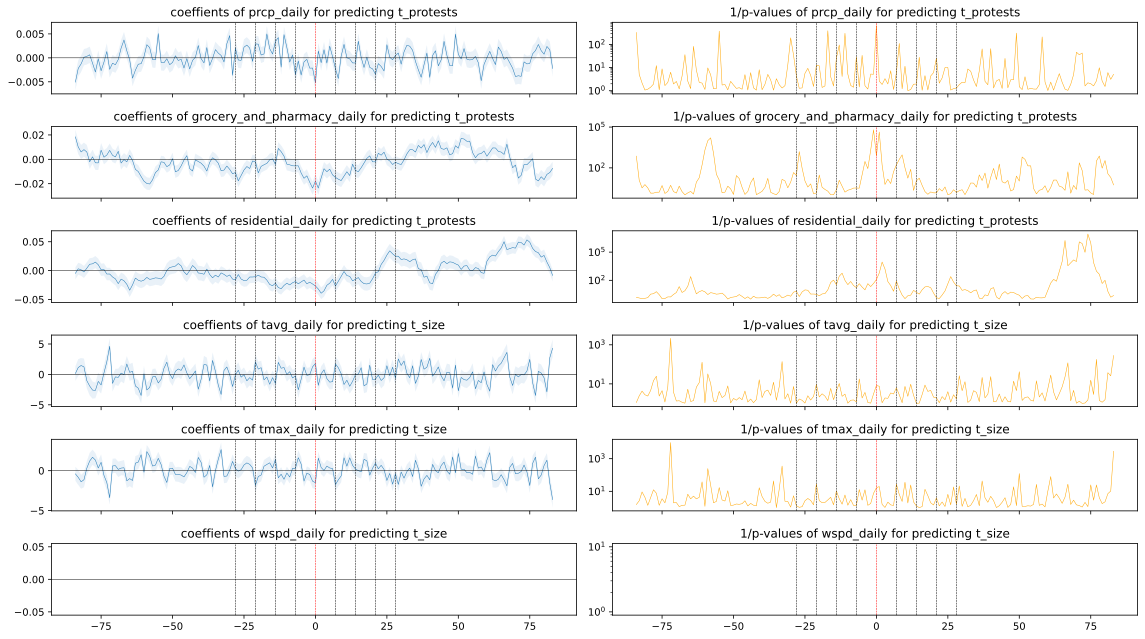

In [100]:
# | label: fig-first-stage-time-series
# | fig-cap: Time series of regression results using weather variables from dates around the protest as predictors. x=0 marks the protest date, and the weather from the surrounding 6 months has been used as predictors for the regression. The y-axis shows the resulting regression coefficients. The orange line gives the development of the long-term weather variable, and the blue line gives the development of the daily weather variable. The shaded areas are bands for the standard error (without adjustment for multiple testing). The smoother shape of the long-term weather variable is due to the smoothing procedure. Omitting the smoothing step makes the orange line look more random, but does not notably change the results for the daily weather variable.
# | column: page


def align_yaxis(ax1, v1, ax2, v2):
    # from: https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1 - y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny + dy, maxy + dy)


instruments_ = [
    ("t_protests", "instr_prcp_daily"),
    # ("t_protests", "instr_grocery_and_pharmacy_daily"),
    # ("t_protests", "instr_residential_daily"),
    ("t_size", "instr_tavg_daily"),
    ("t_size", "instr_tmax_daily"),
    ("t_size", "instr_wspd_daily"),
]
fig, axes = plt.subplots(
    len(instruments_), 2, figsize=(16, 1.5 * len(instruments_)), sharex=True
)  # , sharey=True)
for i, varname in enumerate(["coeffients", "1/p-values"]):
    for j, (treatment, predictor) in enumerate(instruments_):
        m = results.query(f"predictor == '{predictor}' & treatment == @treatment")
        ax = axes[j, i]
        if i == 0:
            ax.plot(m["day"], m["coef"], label=treatment, linewidth=0.5)
            ax.fill_between(
                m["day"],
                m["coef"] - m["err"],
                m["coef"] + m["err"],
                alpha=0.1,
            )
            # ax.tick_params(axis="y", labelcolor="blue")
        else:
            # second y-axis
            # ax2 = ax.twinx()
            ax.plot(
                m["day"],
                1 / m["pvalue"],
                label=treatment,
                linewidth=0.5,
                color="orange",
            )
            ax.set_yscale("log")
        # m = results.query(
        #     f"predictor == '{predictor}_longterm_smoothed' & treatment == @treatment"
        # )
        # ax2.plot(
        #     m["day"],
        #     m["coef"],
        #     label=f"{treatment} control",
        #     linewidth=0.5,
        #     color="orange",
        # )
        # ax2.fill_between(
        #     m["day"],
        #     m["coef"] - m["err"],
        #     m["coef"] + m["err"],
        #     alpha=0.1,
        #     color="orange",
        # )
        # ax2.tick_params(axis="y", labelcolor="orange")
        ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
        ax.axvline(0, color="red", linestyle="--", linewidth=0.5)
        ax.axvline(-7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-28, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(28, color="black", linestyle="--", linewidth=0.5)
        ax.set_title(
            f"{varname} of {predictor.replace('instr_', '')} for predicting {treatment}"
        )
        # align_yaxis(ax, 0, ax2, 0)
    # # legend below plot
    # fig.legend(
    #     *axes[0, 0].get_legend_handles_labels(),
    #     loc="lower center",
    #     ncol=2,
    #     bbox_to_anchor=(0.5, 0),
    #     bbox_transform=fig.transFigure,
    # )
fig.tight_layout()
plt.show()

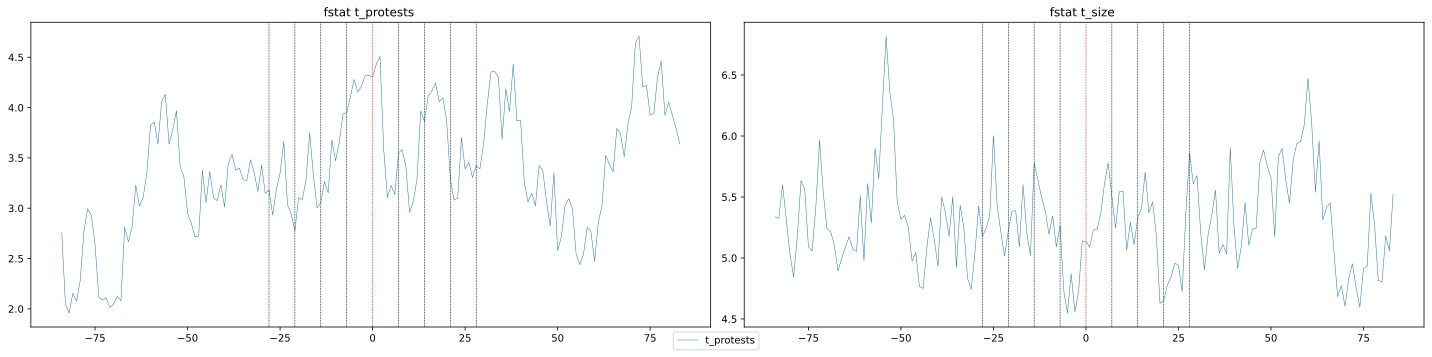

In [101]:
# | label: fig-fstat
# | fig-cap: ...
# | column: page

fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
for j, predictor in enumerate(["instr_prcp"]):
    for i, treatment in enumerate(treatments):
        m = results.query(f"predictor == '{predictor}_daily' & treatment == @treatment")
        ax = axes[i]
        ax.plot(m["day"], m["fstat"], label=treatment, linewidth=0.5)
        # ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
        ax.axvline(0, color="red", linestyle="--", linewidth=0.5)
        ax.axvline(-7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-28, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(28, color="black", linestyle="--", linewidth=0.5)
        # ax.axhline(10, color="green", linestyle="-.")
        ax.set_title(f"fstat {treatment} ")
# legend below plot
fig.legend(
    *axes[0].get_legend_handles_labels(),
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, 0),
)
fig.tight_layout()
plt.show()

In [102]:
X = df[["instr_prcp_daily"] + region_dummies]
X = sm.add_constant(X)
y = df["t_protests"]
results = sm.OLS(y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             t_protests   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.269
Date:                Thu, 22 Jun 2023   Prob (F-statistic):           3.11e-05
Time:                        20:56:26   Log-Likelihood:                 6915.6
No. Observations:               15344   AIC:                        -1.380e+04
Df Residuals:                   15329   BIC:                        -1.369e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0380      0.005      8.049      0.000       0.029       0.047
instr_prcp_daily       -0.0041      0.001     -3.166      0.002      -0.007      -0.002
Berlin                 -0.0188      0.007     -2.821      0.005      -0.032      -0.006
Brandenburg            -0.0104      0.007     -1.547      0.122      -0.024       0.003
Bremen                 -0.0146      0.007     -2.200      0.028      -0.028      -0.002
Hamburg                -0.0244      0.007     -3.680      0.000      -0.037      -0.011
Hessen                 -0.0209      0.007     -3.172      0.002      -0.034      -0.008
Niedersachsen          -0.0106      0.007     -1.597      0.110      -0.024       0.002
Nordrhein-Westfalen    -0.0205      0.007     -3.073      0.002      -0.034      -0.007
Rheinland-Pfalz        -0.0131      0.007     -1.981      0.048      -0.026      -0.000
Saarland               -0.0116      0.007     -1.755      0.079      -0.025       0.001
Sachsen                -0.0196      0.007     -2.953      0.003      -0.033      -0.007
Sachsen-Anhalt         -0.0069      0.007     -1.021      0.307      -0.020       0.006
Schleswig-Holstein     -0.0206      0.007     -3.095      0.002      -0.034      -0.008
Thüringen               0.0021      0.007      0.311      0.756      -0.011       0.015
==============================================================================
Omnibus:                    17193.457   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           912279.319
Skew:                           6.132   Prob(JB):                         0.00
Kurtosis:                      38.728   Cond. No.                         15.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
import statsmodels.api as sm

treatments = ["t_protests", "t_size"]
results = []
protests = df.query("t_protests > 0")
for day in tqdm(np.arange(-28 * 3, 28 * 3)):
    for treatment in treatments:
        df_ = df if treatment == "t_protests" else protests
        for predictor in (
            instruments.original + instruments.daily + instruments.longterm_smoothed
        ):
            instruments_ = [f"{predictor}_{day}"]
            X = df_[instruments_ + region_dummies]
            X = sm.add_constant(X)
            y = df_[treatment]
            r = sm.OLS(y, X).fit()
            var = f"{predictor}_{day}"
            results.append(
                {
                    "treatment": treatment,
                    "predictor": predictor,
                    "day": day,
                    "coef": r.params[var],
                    "err": r.bse[var],
                    "pvalue": r.pvalues[var],
                    "r2": r.rsquared if hasattr(r, "rsquared") else None,
                    "adj_r2": r.rsquared_adj if hasattr(r, "rsquared_adj") else None,
                    "fstat": r.fvalue if hasattr(r, "fvalue") else None,
                    "fstat_pvalue": r.f_pvalue if hasattr(r, "f_pvalue") else None,
                }
            )
results = pd.DataFrame(results)

  0%|          | 0/168 [00:00<?, ?it/s]

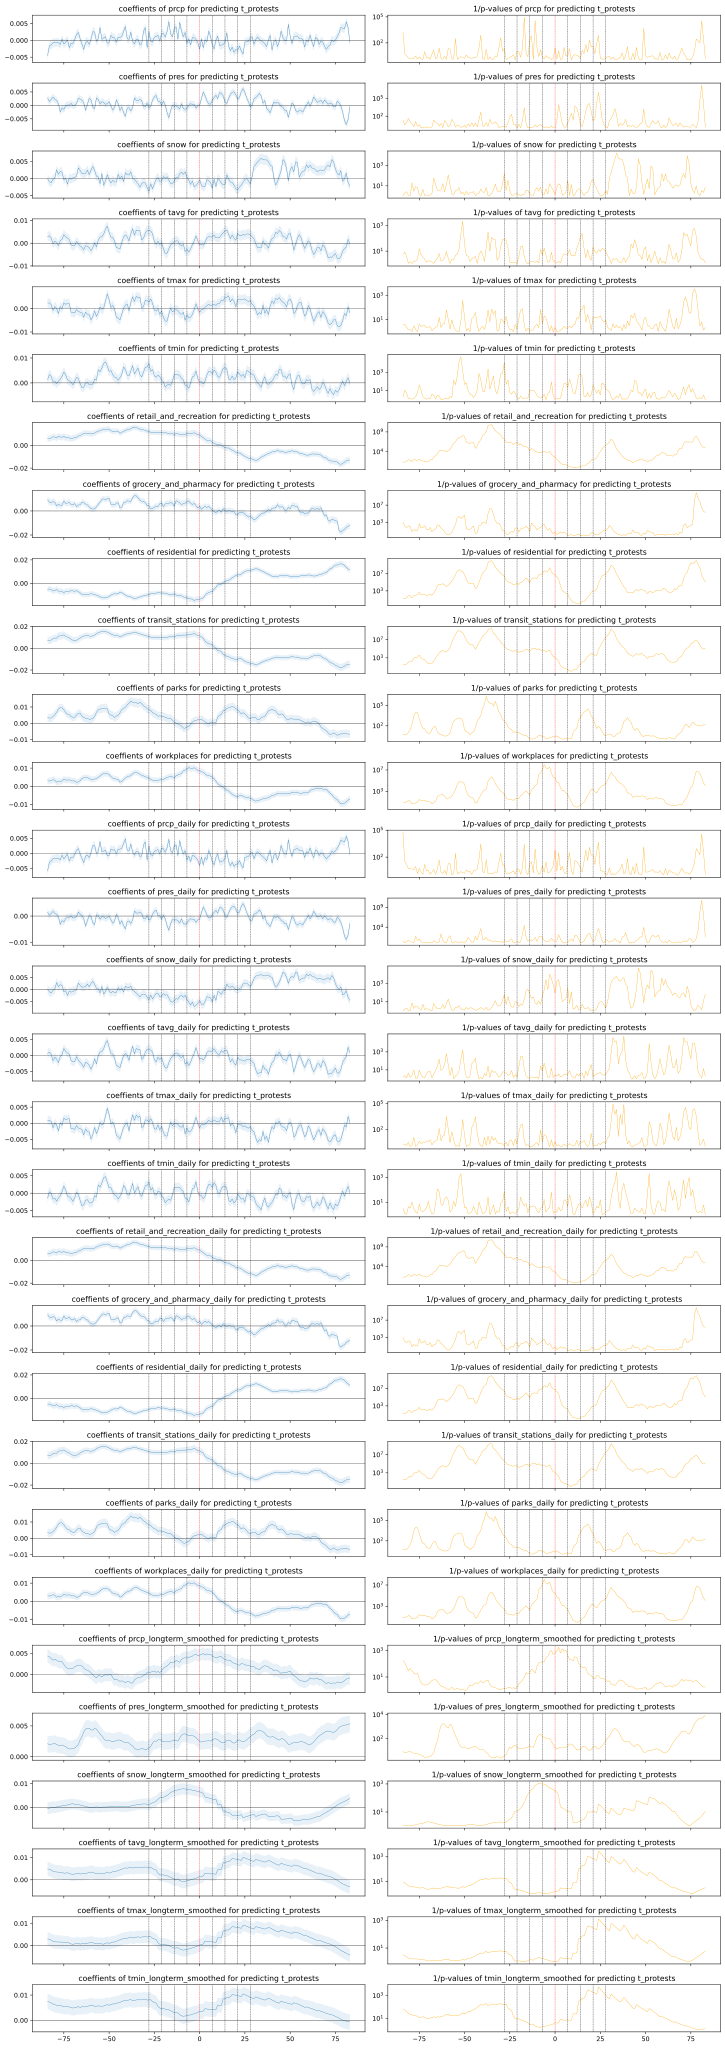

In [108]:
def align_yaxis(ax1, v1, ax2, v2):
    # from: https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1 - y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny + dy, maxy + dy)


instruments_ = instruments.original + instruments.daily + instruments.longterm_smoothed
instruments_ = list(zip(["t_protests"] * len(instruments_), instruments_))
fig, axes = plt.subplots(
    len(instruments_), 2, figsize=(16, 1.5 * len(instruments_)), sharex=True
)  # , sharey=True)
for i, varname in enumerate(["coeffients", "1/p-values"]):
    for j, (treatment, predictor) in enumerate(instruments_):
        m = results.query(f"predictor == '{predictor}' & treatment == @treatment")
        ax = axes[j, i]
        if i == 0:
            ax.plot(m["day"], m["coef"], label=treatment, linewidth=0.5)
            ax.fill_between(
                m["day"],
                m["coef"] - m["err"],
                m["coef"] + m["err"],
                alpha=0.1,
            )
            # ax.tick_params(axis="y", labelcolor="blue")
        else:
            # second y-axis
            # ax2 = ax.twinx()
            ax.plot(
                m["day"],
                1 / m["pvalue"],
                label=treatment,
                linewidth=0.5,
                color="orange",
            )
            ax.set_yscale("log")
        # m = results.query(
        #     f"predictor == '{predictor}_longterm_smoothed' & treatment == @treatment"
        # )
        # ax2.plot(
        #     m["day"],
        #     m["coef"],
        #     label=f"{treatment} control",
        #     linewidth=0.5,
        #     color="orange",
        # )
        # ax2.fill_between(
        #     m["day"],
        #     m["coef"] - m["err"],
        #     m["coef"] + m["err"],
        #     alpha=0.1,
        #     color="orange",
        # )
        # ax2.tick_params(axis="y", labelcolor="orange")
        ax.axhline(0, color="black", linestyle="-", linewidth=0.5)
        ax.axvline(0, color="red", linestyle="--", linewidth=0.5)
        ax.axvline(-7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-28, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(28, color="black", linestyle="--", linewidth=0.5)
        ax.set_title(
            f"{varname} of {predictor.replace('instr_', '')} for predicting {treatment}"
        )
        # align_yaxis(ax, 0, ax2, 0)
    # # legend below plot
    # fig.legend(
    #     *axes[0, 0].get_legend_handles_labels(),
    #     loc="lower center",
    #     ncol=2,
    #     bbox_to_anchor=(0.5, 0),
    #     bbox_transform=fig.transFigure,
    # )
fig.tight_layout()
plt.show()

In [40]:
import pickle

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import f1_score, mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)

# use cross-validation to find good hyperparameters for the model


params_path = (
    project_root / "protest_impact" / "instrumental_variables" / "best_params.pickle"
)

if params_path.exists():
    with open(params_path, "rb") as f:
        hyperopt_results = pickle.load(f)
else:
    hyperopt_results = dict()
    for treatment in treatments:
        print(treatment)

        region_dummies = pd.get_dummies(df["region"], drop_first=True)
        X = pd.concat(
            [df[instruments.daily + instruments.longterm_smoothed], region_dummies],
            axis=1,
        )
        y = df[treatment]

        space = dict(
            n_estimators=[10, 20, 100, 200, 500],
            max_features=["sqrt", "log2"],
            max_depth=[10, 100, 1000],
            min_samples_split=[2, 5, 10],
            min_samples_leaf=[1, 2, 4],
            bootstrap=[True, False],
        )

        if treatment == "t_protests":
            model = RandomForestClassifier()
            space["class_weight"] = ["balanced", "balanced_subsample", None]
            search = GridSearchCV(
                model, space, scoring="f1", n_jobs=-1, cv=5, verbose=0
            )
        else:
            model = RandomForestRegressor()
            search = GridSearchCV(
                model,
                space,
                scoring="neg_mean_squared_error",
                n_jobs=-1,
                cv=5,
                verbose=0,
            )
        hyperopt_result = search.fit(X, y)
        hyperopt_results[treatment] = hyperopt_result
        with open(params_path, "wb") as f:
            pickle.dump(hyperopt_results, f)
for name, results in hyperopt_results.items():
    print(name)
    print("params:", results.best_params_)
    print("score:", results.best_score_)

t_protests
params: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 20}
score: 0.02202972685286613
t_size
params: {'bootstrap': False, 'max_depth': 1000, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
score: -0.9861288463024873


In [41]:
# get feature importances using permutation importance

# would be nice to use https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

importances = dict()
for treatment in treatments:
    print(treatment)
    df_ = df if treatment == "t_protests" else protests
    region_dummies_ = pd.get_dummies(df_["region"], drop_first=True)
    X = pd.concat(
        [df_[instruments.daily + instruments.longterm_smoothed], region_dummies_],
        axis=1,
    )
    y = df_[treatment]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=20220613
    )
    if treatment == "t_protests":
        model = RandomForestClassifier(**hyperopt_results[treatment].best_params_)
        scorer = "f1"
    else:
        model = RandomForestRegressor(**hyperopt_results[treatment].best_params_)
        scorer = "neg_mean_squared_error"
    model.fit(X_train, y_train)
    result = permutation_importance(
        model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring=scorer
    )
    importances[treatment] = result

t_protests
t_size


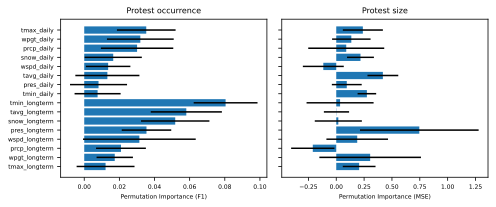

In [42]:
# | label: fig-feature-importances
# | fig-cap: Feature importances!
# | out-width: 30%

# plot importances

import matplotlib as mpl

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
for i, treatment in enumerate(treatments):
    result = importances[treatment]
    sorted_idx = result.importances_mean.argsort()
    # only keep features with non-zero importance
    sorted_idx = sorted_idx[result.importances_mean[sorted_idx] != 0]
    # only keep features with "instr" in name
    sorted_idx = sorted_idx[["instr" in name for name in X.columns[sorted_idx]]]
    # group the index by names that contain "daily" and "longterm"
    sorted_idx = sorted(sorted_idx, key=lambda x: "daily" in X.columns[x])
    ax = axes.flatten()[i]
    ax.barh(
        X.columns[sorted_idx],
        result.importances_mean[sorted_idx],
        xerr=result.importances_std[sorted_idx],
        align="center",
    )
    names = [
        name.replace("instr_", "").replace("_smoothed", "")
        for name in X.columns[sorted_idx]
    ]
    ax.set_yticks(range(len(names)), names)
    # ax.axvline(0, color="black", linestyle="--", linewidth=0.5)
    ax.set_title(
        "Protest occurrence" if treatment == "t_protests" else "Protest size",
        fontsize=8,
    )
    ax.set_xlabel(
        "Permutation Importance " + ("(F1)" if treatment == "t_protests" else "(MSE)"),
        fontsize=6,
    )
    # smaller font soze
    ax.tick_params(axis="both", which="major", labelsize=6)
fig.tight_layout()
# for layout, consider https://stackoverflow.com/questions/61068411/how-to-center-shared-y-labels-for-two-horizontal-bar-plots
plt.show()

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)

treatments = ["t_protests", "t_size"]
results = []
protests = df.query("t_protests > 0")
for day in tqdm(np.arange(-3 * 28, 3 * 28)):
    for treatment in treatments:
        df_ = df if treatment == "t_protests" else protests
        instruments_ = [
            f"{instr}_{day}"
            for instr in instruments.daily + instruments.longterm_smoothed
        ]
        region_dummies = pd.get_dummies(df_["region"], drop_first=True)
        X = pd.concat([df_[instruments_], region_dummies], axis=1)
        y = df_[treatment]
        # cross validation
        cv = KFold(n_splits=2, shuffle=True, random_state=20220613)
        if treatment == "t_protests":
            model = RandomForestClassifier(**hyperopt_results[treatment].best_params_)
            scores = cross_validate(
                model, X, y, cv=cv, scoring=["r2", "mse", "f1"], n_jobs=-1
            )
        else:
            model = RandomForestRegressor(**hyperopt_results[treatment].best_params_)
            scores = cross_validate(
                model, X, y, cv=cv, scoring=["r2", "neg_mean_squared_error"], n_jobs=-1
            )

        # feature importance
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True, random_state=20220613
        )
        model.fit(X_train, y_train)
        result = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=20220613, n_jobs=-1
        )
        importances = pd.DataFrame(
            {
                "feature": X.columns,
                "importance_mean": result.importances_mean,
                "importance_std": result.importances_std,
            }
        )

        results.append(
            {
                "treatment": treatment,
                "day": day,
                "r2": scores["test_r2"].mean(),
                "r2_std": scores["test_r2"].std(),
                "mse": -scores["test_neg_mean_squared_error"].mean()
                if treatment == "t_size"
                else None,
                "mse_std": scores["test_neg_mean_squared_error"].std()
                if treatment == "t_size"
                else None,
                "f1": scores["test_f1"].mean() if treatment == "t_protests" else None,
                "f1_std": scores["test_f1"].std()
                if treatment == "t_protests"
                else None,
                "importances": importances,
            }
        )
results = pd.DataFrame(results)

  0%|          | 0/168 [00:00<?, ?it/s]

ValueError: 'mse' is not a valid scoring value. Use sklearn.metrics.get_scorer_names() to get valid options.

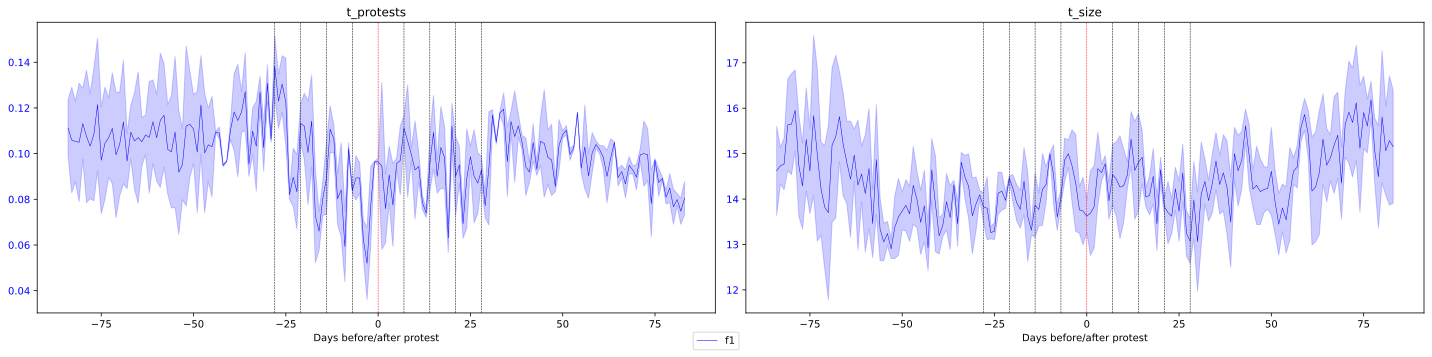

In [ ]:
# | label: fig-random-forests-time-series
# | fig-cap: Time series of the performance of random forests.


def get_importances(m, var_name, stat="mean"):
    return np.array(
        [
            m["importances"]
            .iloc[i]
            .query(f"feature.str.contains('{var_name}')")[f"importance_{stat}"]
            .values[0]
            for i in range(-3 * 28, 3 * 28)
        ]
    )


fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
for i, treatment in enumerate(treatments):
    m = results.query(f"treatment == @treatment")
    ax = axes[i]
    # ax.plot(m["day"], m["r2"], label="r2", linewidth=0.5, color="red")
    # ax.tick_params(axis="y", labelcolor="red")
    metrics = ["mse", "f1"] if treatment == "t_protests" else ["mse"]
    for metric in metrics:
        ax.plot(m["day"], m[metric], label=metric, linewidth=0.5)
        ax.fill_between(
            m["day"],
            m[metric] - m[f"{metric}_std"],
            m[metric] + m[f"{metric}_std"],
            alpha=0.2,
        )
    ax.set_xlabel("Days before/after protest")
    ax.set_title(treatment)
    ax.tick_params(axis="y", labelcolor="blue")
    ax.axvline(0, color="red", linestyle="--", linewidth=0.5)
    ax.axvline(-7, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(-14, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(-21, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(-28, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(7, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(14, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(21, color="black", linestyle="--", linewidth=0.5)
    ax.axvline(28, color="black", linestyle="--", linewidth=0.5)
    # align_yaxis(ax, 0, ax2, 0)
    ax.legend(loc="upper left")
fig.tight_layout()
plt.show()

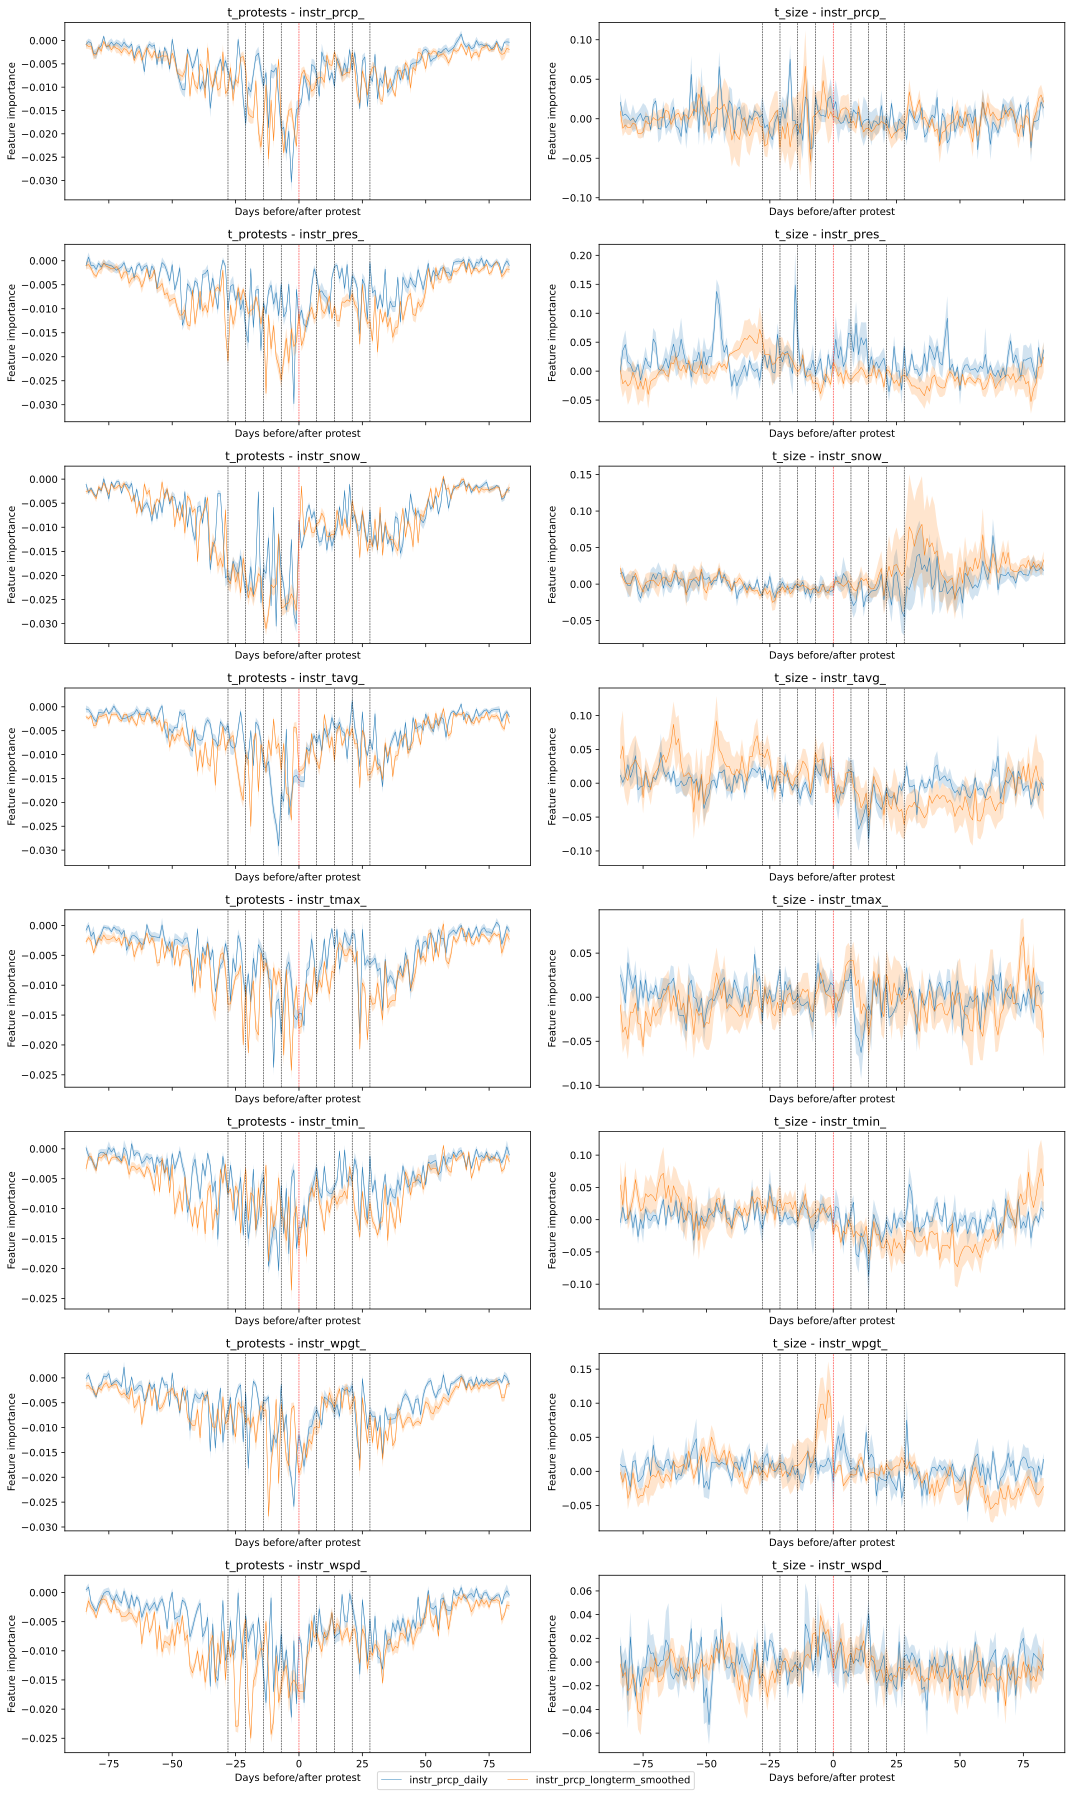

In [ ]:
fig, axes = plt.subplots(
    len(instruments.daily), 2, figsize=(15, 20), sharex=True
)  # , sharey=True)
for i, treatment in enumerate(treatments):
    for j, (instr_daily, instr_longterm) in enumerate(
        zip(instruments.daily, instruments.longterm_smoothed)
    ):
        m = results.query(f"treatment == @treatment")
        ax = axes[j, i]
        for instr in [instr_daily, instr_longterm]:
            ax.plot(m["day"], get_importances(m, instr), label=instr, linewidth=0.5)
            ax.fill_between(
                m["day"],
                get_importances(m, instr, stat="mean")
                - get_importances(m, instr, stat="std"),
                get_importances(m, instr, stat="mean")
                + get_importances(m, instr, stat="std"),
                alpha=0.2,
            )
        ax.set_title(f"{treatment} - {instr_daily.replace('daily', ' ')}")
        ax.axvline(0, color="red", linestyle="--", linewidth=0.5)
        ax.axvline(-7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(-28, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(7, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(14, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(21, color="black", linestyle="--", linewidth=0.5)
        ax.axvline(28, color="black", linestyle="--", linewidth=0.5)
        ax.set_xlabel("Days before/after protest")
        ax.set_ylabel("Feature importance")

# legend below plot
fig.legend(
    *axes[0, 0].get_legend_handles_labels(),
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, 0),
)
fig.tight_layout()
plt.show()